In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
from dataclasses import replace
import json
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from src.analysis.state_space import prepare_word_trajectory_spec, prepare_state_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings

In [5]:
# model_checkpoint = "../out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
model_dir = "outputs/models/w2v2_32/phoneme_within_word_prefix"
model_dir = "outputs/models/w2v2_8/phoneme"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"

state_space_spec = "out/state_space_specs/all_words.pkl"
complex_cohort_spec = "complex_cohort_set.json"

out = "out/state_space/phoneme_6_1/complex_cohort.gif"

In [6]:
Path(out).parent.mkdir(parents=True, exist_ok=True)

In [7]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [8]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [9]:
with open(state_space_spec, "rb") as f:
    state_space_spec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [10]:
with open(complex_cohort_spec, "r") as f:
    cohort_spec = json.load(f)

In [11]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [12]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [13]:
# Subset state space based on cohort of interest
target_word, (prefix_overlaps, suffix_overlaps) = next(iter(cohort_spec.items()))
all_words = [target_word] + prefix_overlaps + suffix_overlaps

match_idxs = [idx for idx, word in enumerate(state_space_spec.labels) if word in all_words]
is_prefix = np.array([state_space_spec.labels[idx] in prefix_overlaps for idx in match_idxs])
is_suffix = np.array([state_space_spec.labels[idx] in suffix_overlaps for idx in match_idxs])
state_space_spec = replace(state_space_spec,
                           labels=[state_space_spec.labels[idx] for idx in match_idxs],
                           target_frame_spans=[state_space_spec.target_frame_spans[idx] for idx in match_idxs])

In [14]:
trajectory = prepare_state_trajectory(model_representations_pca, state_space_spec)

In [15]:
len(trajectory), trajectory[0].shape

(31, (7, 61, 2))

In [19]:
min, max = np.concatenate(trajectory).min(), np.concatenate(trajectory).max()

In [17]:
is_prefix

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True,  True, False, False,  True, False, False,  True,
       False, False,  True, False])

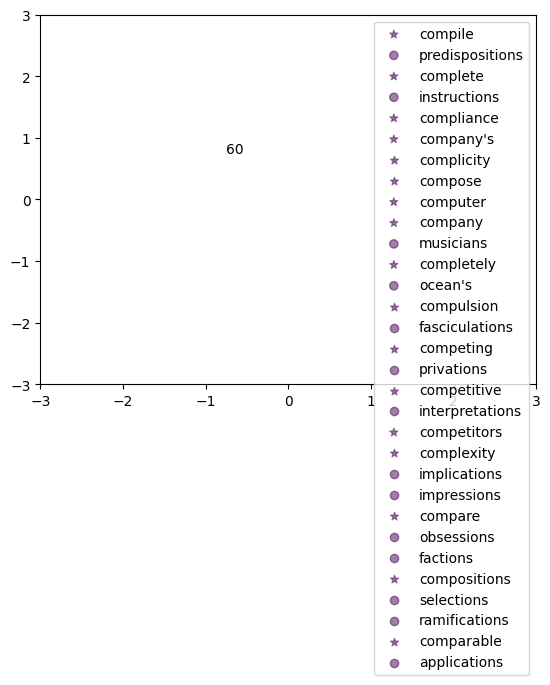

In [20]:
# Animate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(np.floor(min), np.ceil(max))
ax.set_ylim(np.floor(min), np.ceil(max))
annot_frame = ax.text(-0.75, 0.75, "-1")
scats = [ax.scatter(np.zeros(traj_i.shape[0]), np.zeros(traj_i.shape[0]),
                    alpha=0.5,
                    marker="*" if is_prefix[i] else "o",
                    c=np.zeros(traj_i.shape[0]),
               #  c=np.repeat(100 * int(is_prefix[i]), traj_i.shape[0]),
               # cmap="viridis"
                   ) for i, traj_i in enumerate(trajectory)]
ax.legend(scats, state_space_spec.labels, loc=1)

def init():
    for scat in scats:
        scat.set_offsets(np.zeros((0, 2)))
    return tuple(scats)

def update(frame):
    for scat, traj_i, is_prefix_i in zip(scats, trajectory, is_prefix):
        scat.set_offsets(traj_i[:, frame])
        # set color
        # scat.set_array(np.repeat(100 * int(is_prefix_i), traj_i.shape[0]))
    annot_frame.set_text(str(frame))
    return tuple(scats) + (annot_frame,)

# Animate by model frame
num_frames = trajectory[0].shape[1]
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=500,
                              init_func=init)
ani.save(out)